In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import geopandas as gpd

import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Read data

In [2]:
df_soc = pd.read_csv('/Users/julianeoliveira/Downloads/df_socio_clusters_k6.csv')

In [3]:
df = pd.read_parquet('/Users/julianeoliveira/Downloads/aesop_2025_10_01_mun_withNewEnsIvas.parquet')

In [4]:
df_soc = df_soc[['CD_MUN','NM_MUN','CD_UF','NM_UF','SIGLA_UF','cluster']]

In [5]:
lst = ['sigla_uf','co_uf','nm_uf',
 'nm_municipio','co_ibge',  'co_ibge7',
 'epiyear','epiweek','epidemi_cal_start', 'year_week',
 'atend_totais','atend_ivas',
 'sinal_ens_ivas','sinal_otc_ivas','Aviso AESOP',
 'alerta_vizinho', 'aviso_vizinho','sinais_vizinhos',
 'mem_surge', 'mem_surge_01',
 'risk_probs', 'sinal_ens_ivas_new',
 'dqi','P_growth_otc_ivas', 'P_growth_aps_ivas','prob_gro_trend_ivas']

In [6]:
data = df[lst].copy()

In [7]:
ibp = pd.read_csv('/Users/julianeoliveira/Documents/Projects/AESOP/AESOP datalake/Socio_economic/data-cidacs_ipb_municipios.csv')
ibp = ibp[['ip_cd_m','ip_vl_n']]

ibp = ibp.assign(co_ibge = ibp.ip_cd_m.astype(str).str[0:6])

ibp = ibp[['ip_cd_m','co_ibge','ip_vl_n']]

In [8]:
data = data[data.year_week < '2025-36']

# Prepare data to run the model

In [9]:
dta_week = data[data.year_week == '2022-42']#

In [10]:
df_merged = df_soc.merge(
    dta_week,
    left_on="CD_MUN",
    right_on="co_ibge7",
    how="left"   
)

In [11]:
df_merged = df_merged.merge(
    ibp,
    left_on="CD_MUN",
    right_on="ip_cd_m",
    how="left"   
)

In [12]:
df_merged= df_merged.rename(columns = { 'ip_vl_n':'ibp'})

In [13]:
df_merged


# Suppose your variable is called "value" inside df
bins = [-1.7627, -1.0024, -0.4717, 0.2507, 1.0266, 2.7295]
labels = [
    "0", #-1.7627 à -1.0024
    "1", #-1.0023 à -0.4717
    "2", #-0.4717 à 0.2507
    "3", #0.2507 à 1.0265
    "4" #1.0266 à 2.7295
]

df_merged["ibp_cat"] = pd.cut(df_merged["ibp"], bins=bins, labels=labels, include_lowest=True)


In [14]:
# Subset
dta_model = df_merged[['cluster','Aviso AESOP']].dropna() #sinal_ens_ivas

In [15]:
contingency = pd.crosstab(dta_model['cluster'], dta_model['Aviso AESOP'])
chi2, p, dof, expected = stats.chi2_contingency(contingency)
print(f"Chi2={chi2:.2f}, p={p:.3g}")

Chi2=0.00, p=1


# Method of analyses

1) we will construct a contigency table to study the joint relationship or correlation between the classes and the warnings issued by week. 

2) We will use the chi-square test to the observed frequencies to determine if the relationship between the variables is statistically significant. 


# Analise da associação dos avisos e caracteristicas socioeconomicas (cluster k = 6 e ibp) 

In [16]:
def chi_pvalor_aviso(dta, classe_socio, warning):
    
    contingency = pd.crosstab(dta[classe_socio], dta[warning])
    chi2, p, dof, expected = stats.chi2_contingency(contingency)
    
    return chi2, p
    

In [17]:
lst_res = []

# define bins and labels once outside the loop
bins = [-1.7627, -1.0024, -0.4717, 0.2507, 1.0266, 2.7295]
labels = [0, 1, 2, 3, 4]  # numeric labels easier to work with

for week in data.year_week.unique():
    
    # prepare data for analysis
    dta_week = data[data.year_week == week].copy()
    
    df_merged = df_soc.merge(
        dta_week,
        left_on="CD_MUN",
        right_on="co_ibge7",
        how="left"   
    )

    df_merged = df_merged.merge(
        ibp,
        left_on="CD_MUN",
        right_on="ip_cd_m",
        how="left"   
    )

    df_merged = df_merged.rename(columns={'ip_vl_n':'ibp'})
    
    # create ibp categories
    df_merged["ibp_cat"] = pd.cut(
        df_merged["ibp"], 
        bins=bins, 
        labels=labels, 
        include_lowest=True
    )
    
    # outcomes to test
    outcomes = ['Aviso AESOP', 'sinal_otc_ivas', 'sinal_ens_ivas', 'sinal_ens_ivas_new']
    
    # results dict for this week
    res_dict = {
        "epiyear": dta_week.epiyear.iloc[0],
        "epiweek": dta_week.epiweek.iloc[0],
        "epidemi_cal_start": dta_week.epidemi_cal_start.iloc[0],
        "year_week": week,
    }
    
    # loop over outcomes and calculate for both cluster and ibp_cat
    for outcome in outcomes:
        chi2_c, p_c = chi_pvalor_aviso(df_merged, 'cluster', outcome)
        chi2_i, p_i = chi_pvalor_aviso(df_merged, 'ibp_cat', outcome)
        
        # store results with clear variable names
        res_dict[f"chi2_{outcome}_cluster"] = chi2_c
        res_dict[f"p_{outcome}_cluster"] = p_c
        res_dict[f"chi2_{outcome}_ibp_cat"] = chi2_i
        res_dict[f"p_{outcome}_ibp_cat"] = p_i
    
    # wrap as dataframe row
    dta_res = pd.DataFrame([res_dict])
    lst_res.append(dta_res)

# final results
results = pd.concat(lst_res, ignore_index=True)


In [18]:
#results.to_csv('/Users/julianeoliveira/Downloads/p-values_socio_08_10_25.csv')

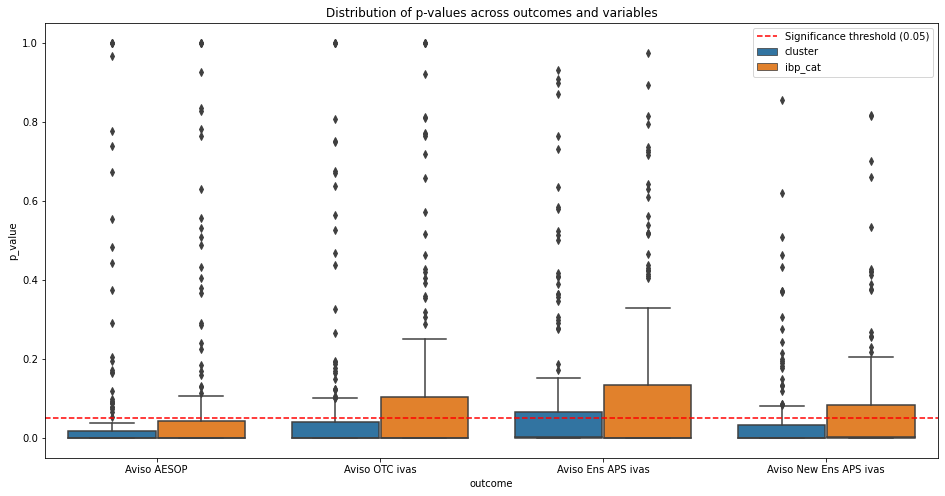

In [19]:
# select only the p-value columns
pval_cols = [col for col in results.columns if col.startswith("p_")]

# reshape to long format for easier plotting
df_long = results.melt(
    id_vars=["year_week"], 
    value_vars=pval_cols, 
    var_name="test", 
    value_name="p_value"
)

# split outcome and variable type (cluster vs ibp_cat)
df_long["outcome"] = df_long["test"].replace({'p_Aviso AESOP_cluster': 'Aviso AESOP',
                                              'p_Aviso AESOP_ibp_cat': 'Aviso AESOP',
                                             'p_sinal_otc_ivas_cluster': 'Aviso OTC ivas', 
                                             'p_sinal_otc_ivas_ibp_cat': 'Aviso OTC ivas',
                                             'p_sinal_ens_ivas_cluster': 'Aviso Ens APS ivas',
                                             'p_sinal_ens_ivas_ibp_cat': 'Aviso Ens APS ivas',
                                             'p_sinal_ens_ivas_new_cluster': 'Aviso New Ens APS ivas', 
                                              'p_sinal_ens_ivas_new_ibp_cat': 'Aviso New Ens APS ivas'})

df_long["variable"] = df_long["test"].apply(lambda x: "cluster" if "cluster" in x else "ibp_cat")

# boxplot
plt.figure(figsize=(16,8))
sns.boxplot(data=df_long, x="outcome", y="p_value", hue="variable")
plt.axhline(0.05, color="red", linestyle="--", label="Significance threshold (0.05)")
plt.title("Distribution of p-values across outcomes and variables")
plt.legend()
plt.show()


In [20]:
for col in pval_cols:
    n = round(len(results[results[col] <= 0.05])*100/len(results),1)
    
    print(col , n)

p_Aviso AESOP_cluster 80.7
p_Aviso AESOP_ibp_cat 75.3
p_sinal_otc_ivas_cluster 75.3
p_sinal_otc_ivas_ibp_cat 69.3
p_sinal_ens_ivas_cluster 71.3
p_sinal_ens_ivas_ibp_cat 69.3
p_sinal_ens_ivas_new_cluster 78.0
p_sinal_ens_ivas_new_ibp_cat 69.3


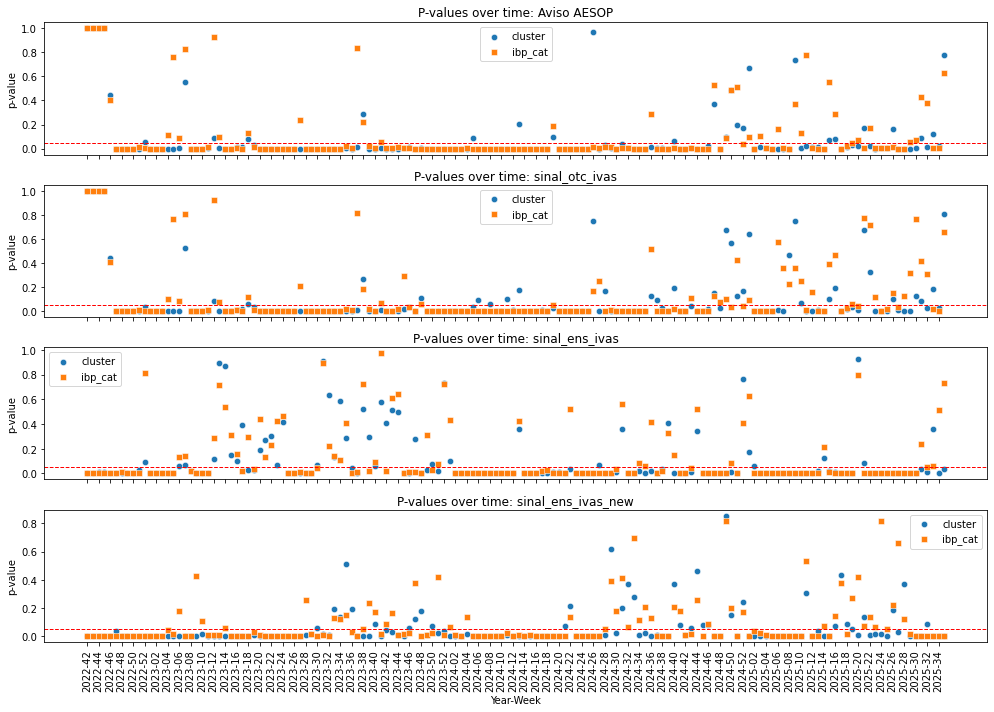

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# outcomes list
outcomes = ["Aviso AESOP", "sinal_otc_ivas", "sinal_ens_ivas", "sinal_ens_ivas_new"]

# setup subplots
fig, axes = plt.subplots(len(outcomes), 1, figsize=(14, 10), sharex=True)

for i, outcome in enumerate(outcomes):
    ax = axes[i]
    
    # plot cluster
    sns.scatterplot(
        data=results, 
        x="year_week", 
        y=f"p_{outcome}_cluster", 
        ax=ax, 
        label="cluster", 
        marker="o", 
        s=40
    )
    
    # plot ibp_cat
    sns.scatterplot(
        data=results, 
        x="year_week", 
        y=f"p_{outcome}_ibp_cat", 
        ax=ax, 
        label="ibp_cat", 
        marker="s", 
        s=40
    )
    
    # threshold line
    ax.axhline(0.05, color="red", linestyle="--", linewidth=1)
    
    # formatting
    ax.set_title(f"P-values over time: {outcome}")
    ax.set_ylabel("p-value")
    ax.set_xlabel("")
    ax.legend()
    # x-axis ticks (reduce clutter)
    ax.set_xticks(results["year_week"][::2])  # every 2 weeks
    ax.set_xticklabels(results["year_week"][::2], rotation=90)

# rotate x labels in the last subplot
axes[-1].set_xlabel("Year-Week")
plt.xticks(rotation=90)


plt.tight_layout()
plt.show()


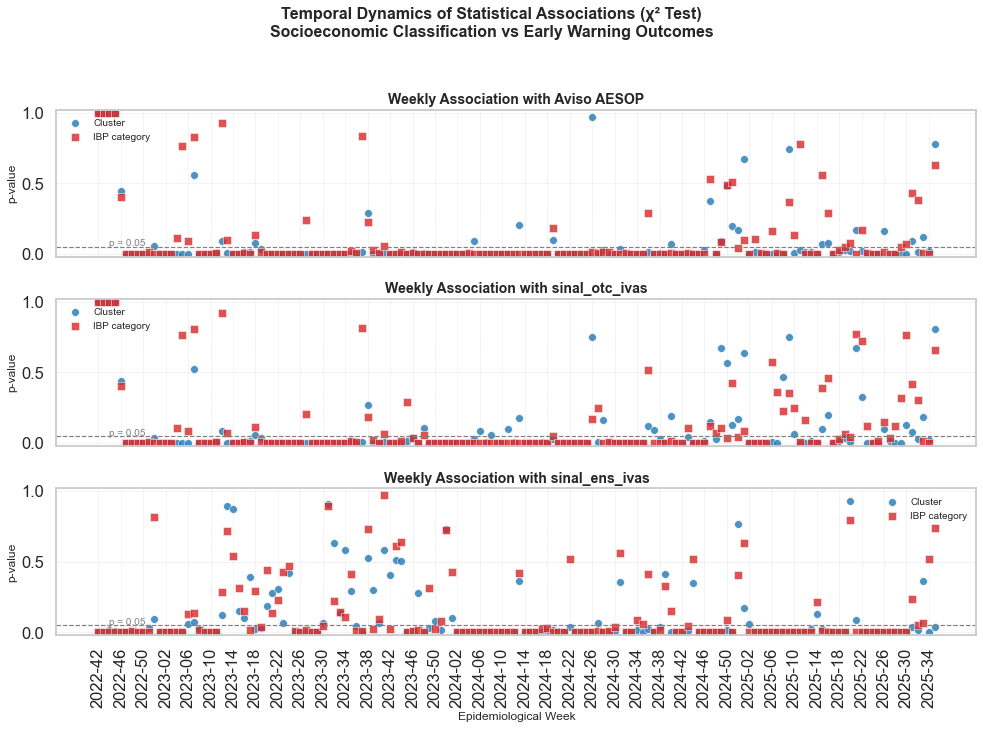

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Outcomes list
outcomes = ["Aviso AESOP", "sinal_otc_ivas", "sinal_ens_ivas"]

# Global style
sns.set(style="whitegrid", context="talk")

# Create subplots
fig, axes = plt.subplots(len(outcomes), 1, figsize=(14, 10), sharex=True)

for i, outcome in enumerate(outcomes):
    ax = axes[i]

    # Plot cluster association (circles)
    sns.scatterplot(
        data=results,
        x="year_week",
        y=f"p_{outcome}_cluster",
        ax=ax,
        label="Cluster",
        marker="o",
        s=60,
        color="#1f77b4",
        alpha=0.8
    )

    # Plot socioeconomic index association (squares)
    sns.scatterplot(
        data=results,
        x="year_week",
        y=f"p_{outcome}_ibp_cat",
        ax=ax,
        label="IBP category",
        marker="s",
        s=60,
        color="#d62728",
        alpha=0.8
    )

    # Add significance threshold line
    ax.axhline(0.05, color="gray", linestyle="--", linewidth=1.2)
    ax.text(results["year_week"].iloc[2], 0.055, "p = 0.05", color="gray", fontsize=10)

    # Formatting
    ax.set_title(f"Weekly Association with {outcome}", fontsize=14, weight="bold")
    ax.set_ylabel("p-value", fontsize=12)
    ax.legend(frameon=False, fontsize=10)
    ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)

    # Y-axis scale: zoom near 0 if needed
    ax.set_ylim(-0.02, 1.02)

# X-axis formatting (only in last plot)
axes[-1].set_xlabel("Epidemiological Week", fontsize=12)
axes[-1].set_xticks(results["year_week"][::4])
axes[-1].set_xticklabels(results["year_week"][::4], rotation=90)

plt.suptitle(
    "Temporal Dynamics of Statistical Associations (χ² Test)\nSocioeconomic Classification vs Early Warning Outcomes",
    fontsize=16,
    weight="bold",
    y=1.02
)

plt.tight_layout()
plt.show()


In [23]:
def odds_ratios_ci(data, predictor, outcome):
    """
    Logistic regression to get odds ratios and 95% CIs.
    Uses the first category (alphabetical/numeric) as reference.
    Removes the intercept row.
    """
    # ensure categorical
    data[predictor] = data[predictor].astype("category")

    # fit logistic regression
    model = smf.logit(f"{outcome} ~ C({predictor})", data=data).fit(disp=0)

    # OR + CI
    conf = model.conf_int()
    conf['OR'] = model.params
    conf.columns = ['2.5%', '97.5%', 'OR']
    conf = np.exp(conf)

    # remove intercept
    conf = conf.drop(index="Intercept")

    return conf.reset_index().rename(columns={'index': 'term'})


In [24]:
df_soc.cluster = df_soc.cluster.replace({1: 0, 0: 1})

In [25]:
data.year_week.unique()

array(['2022-42', '2022-43', '2022-44', '2022-45', '2022-46', '2022-47',
       '2022-48', '2022-49', '2022-50', '2022-51', '2022-52', '2023-01',
       '2023-02', '2023-03', '2023-04', '2023-05', '2023-06', '2023-07',
       '2023-08', '2023-09', '2023-10', '2023-11', '2023-12', '2023-13',
       '2023-14', '2023-15', '2023-16', '2023-17', '2023-18', '2023-19',
       '2023-20', '2023-21', '2023-22', '2023-23', '2023-24', '2023-25',
       '2023-26', '2023-27', '2023-28', '2023-29', '2023-30', '2023-31',
       '2023-32', '2023-33', '2023-34', '2023-35', '2023-36', '2023-37',
       '2023-38', '2023-39', '2023-40', '2023-41', '2023-42', '2023-43',
       '2023-44', '2023-45', '2023-46', '2023-47', '2023-48', '2023-49',
       '2023-50', '2023-51', '2023-52', '2024-01', '2024-02', '2024-03',
       '2024-04', '2024-05', '2024-06', '2024-07', '2024-08', '2024-09',
       '2024-10', '2024-11', '2024-12', '2024-13', '2024-14', '2024-15',
       '2024-16', '2024-17', '2024-18', '2024-19', 

In [26]:
lst_res_ods = []

# define bins and labels once outside the loop
bins = [-1.7627, -1.0024, -0.4717, 0.2507, 1.0266, 2.7295]
labels = [0, 1, 2, 3, 4]  # numeric labels easier to work with

outcomes = ['Aviso_AESOP', 'sinal_otc_ivas', 'sinal_ens_ivas', 'sinal_ens_ivas_new']

lts_week = ['2025-01', '2025-02', '2025-03', '2025-04', '2025-05',
       '2025-06', '2025-07', '2025-08', '2025-09', '2025-10', '2025-11',
       '2025-12', '2025-13', '2025-14', '2025-15', '2025-16', '2025-17',
       '2025-18', '2025-19', '2025-20', '2025-21', '2025-22', '2025-23',
       '2025-24', '2025-25', '2025-26', '2025-27', '2025-28', '2025-29',
       '2025-30', '2025-31', '2025-32', '2025-33', '2025-34', '2025-35']

for week in lts_week:#data.year_week.unique():
    print(week)
    
    # prepare data for analysis
    dta_week = data[data.year_week == week].copy()
    
    df_merged = df_soc.merge(
        dta_week,
        left_on="CD_MUN",
        right_on="co_ibge7",
        how="left"   
    )

    df_merged = df_merged.merge(
        ibp,
        left_on="CD_MUN",
        right_on="ip_cd_m",
        how="left"   
    )

    df_merged = df_merged.rename(columns={'ip_vl_n':'ibp'})
    
    # create ibp categories
    df_merged["ibp_cat"] = pd.cut(
        df_merged["ibp"], 
        bins=bins, 
        labels=labels, 
        include_lowest=True
    )
    
    df_merged = df_merged.rename(columns={'Aviso AESOP': 'Aviso_AESOP'})
    
    # store all results for this week
    lst_ods_out = []

    for outcome in outcomes:
        # OR for cluster
        or_cluster = odds_ratios_ci(df_merged, predictor="cluster", outcome=outcome).assign(
            predictor="cluster", outcome=outcome, week=week
        )

        # OR for ibp_cat
        or_ibp = odds_ratios_ci(df_merged, predictor="ibp_cat", outcome=outcome).assign(
            predictor="ibp_cat", outcome=outcome, week=week
        )

        lst_ods_out.append(pd.concat([or_cluster, or_ibp], ignore_index=True))
    
    lst_res_ods.append(pd.concat(lst_ods_out, ignore_index=True))


# Final tidy dataset with all odds ratios
results_odds = pd.concat(lst_res_ods, ignore_index=True)

2025-01


/Users/julianeoliveira/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/julianeoliveira/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


2025-02
2025-03
2025-04
2025-05
2025-06
2025-07
2025-08
2025-09
2025-10
2025-11
2025-12
2025-13
2025-14
2025-15
2025-16
2025-17
2025-18
2025-19
2025-20
2025-21
2025-22
2025-23
2025-24
2025-25
2025-26
2025-27
2025-28
2025-29
2025-30
2025-31
2025-32


/Users/julianeoliveira/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2025-33


/Users/julianeoliveira/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/julianeoliveira/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


2025-34


/Users/julianeoliveira/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/julianeoliveira/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)
/Users/julianeoliveira/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/julianeoliveira/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


2025-35


/Users/julianeoliveira/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/julianeoliveira/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)
/Users/julianeoliveira/opt/anaconda3/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


In [27]:
#results_odds.to_csv('/Users/julianeoliveira/Downloads/odds_socio_08_10_25.csv')

In [28]:
results_odds[(results_odds.outcome == 'Aviso_AESOP') & (results_odds.predictor == 'cluster') ][['term', '2.5%', '97.5%', 'OR',  'week']]

,term,2.5%,97.5%,OR,week
0,C(cluster)[T.1],0.733889,1.433160,1.025564,2025-01
1,C(cluster)[T.2],0.472211,2.061399,0.986618,2025-01
2,C(cluster)[T.3],0.612263,2.491168,1.235010,2025-01
3,C(cluster)[T.4],0.849498,1.636684,1.179136,2025-01
4,C(cluster)[T.5],0.935938,1.799031,1.297606,2025-01
...,...,...,...,...,...
1224,C(cluster)[T.1],0.864357,1.235614,1.033447,2025-35
1225,C(cluster)[T.2],0.729553,1.571451,1.070727,2025-35
1226,C(cluster)[T.3],0.788143,1.726850,1.166621,2025-35
1227,C(cluster)[T.4],0.876341,1.260579,1.051046,2025-35


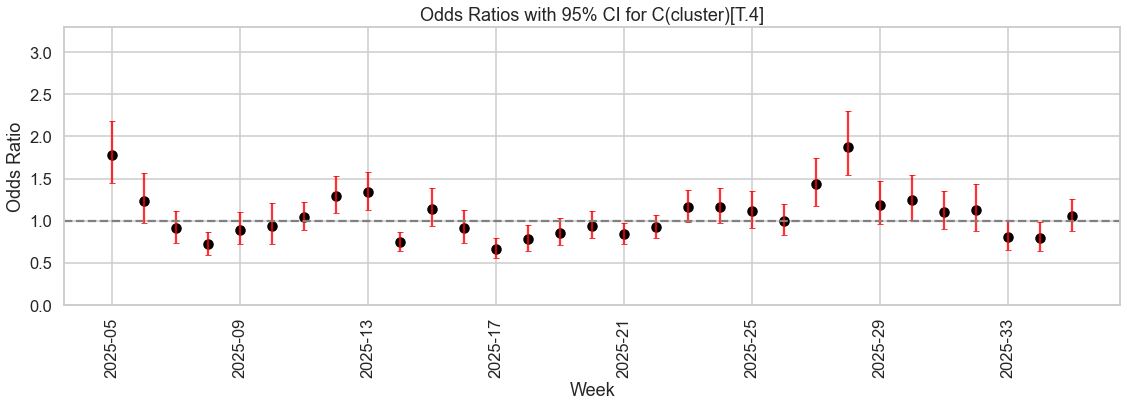

In [29]:
import matplotlib.pyplot as plt

# Filter dataset
df_plot = results_odds[
    (results_odds.outcome == 'Aviso_AESOP') & 
    (results_odds.predictor == 'cluster')
][22:]

# Select term
term_to_plot = "C(cluster)[T.4]"
df_term = df_plot[df_plot["term"] == term_to_plot].copy()

# Create figure
fig, ax = plt.subplots(figsize=(16,6))

# Plot points only
ax.scatter(
    x=range(len(df_term)),
    y=df_term["OR"],
    color="black",
    label="Odds Ratio"
)

# Add error bars for 95% CI
ax.errorbar(
    x=range(len(df_term)),
    y=df_term["OR"],
    yerr=[df_term["OR"] - df_term["2.5%"], df_term["97.5%"] - df_term["OR"]],
    fmt="none",
    ecolor="red",
    capsize=3,
    alpha=0.8
)

# Formatting
ax.axhline(1, color="gray", linestyle="--")  # reference line OR=1

# Show fewer ticks (every 4 weeks)
ax.set_xticks(range(0, len(df_term), 4))
ax.set_xticklabels(df_term["week"].iloc[::4], rotation=90)

# Linear scale (no log)
ax.set_ylim(0, 3 * 1.1)

ax.set_title(f"Odds Ratios with 95% CI for {term_to_plot}")
ax.set_ylabel("Odds Ratio")
ax.set_xlabel("Week")

plt.tight_layout()
plt.show()


In [30]:
df_plot.term.unique()

array(['C(cluster)[T.3]', 'C(cluster)[T.4]', 'C(cluster)[T.5]',
       'C(cluster)[T.1]', 'C(cluster)[T.2]'], dtype=object)

In [31]:
df_plot.replace({'C(cluster)[T.3]': 'Grandes Centros Urbanos c/ Favelas', 
                 'C(cluster)[T.4]': 'Baixa Renda e Baixa Escolaridade',
                'C(cluster)[T.5]': 'Municípios em Desenvolvimento com Saneamento Crítico',
                'C(cluster)[T.1]': 'Pequenos Municípios de Baixa Renda',
                'C(cluster)[T.2]': 'Alta Precariedade (Infraestrutura e Moradia)'})

,term,2.5%,97.5%,OR,predictor,outcome,week
146,Grandes Centros Urbanos c/ Favelas,0.855257,2.197077,1.370790,cluster,Aviso_AESOP,2025-05
147,Baixa Renda e Baixa Escolaridade,1.441458,2.184693,1.774583,cluster,Aviso_AESOP,2025-05
148,Municípios em Desenvolvimento com Saneamento C...,1.232485,1.908925,1.533858,cluster,Aviso_AESOP,2025-05
180,Pequenos Municípios de Baixa Renda,0.629205,1.059897,0.816635,cluster,Aviso_AESOP,2025-06
181,Alta Precariedade (Infraestrutura e Moradia),0.842012,2.197032,1.360120,cluster,Aviso_AESOP,2025-06
...,...,...,...,...,...,...,...
1224,Pequenos Municípios de Baixa Renda,0.864357,1.235614,1.033447,cluster,Aviso_AESOP,2025-35
1225,Alta Precariedade (Infraestrutura e Moradia),0.729553,1.571451,1.070727,cluster,Aviso_AESOP,2025-35
1226,Grandes Centros Urbanos c/ Favelas,0.788143,1.726850,1.166621,cluster,Aviso_AESOP,2025-35
1227,Baixa Renda e Baixa Escolaridade,0.876341,1.260579,1.051046,cluster,Aviso_AESOP,2025-35


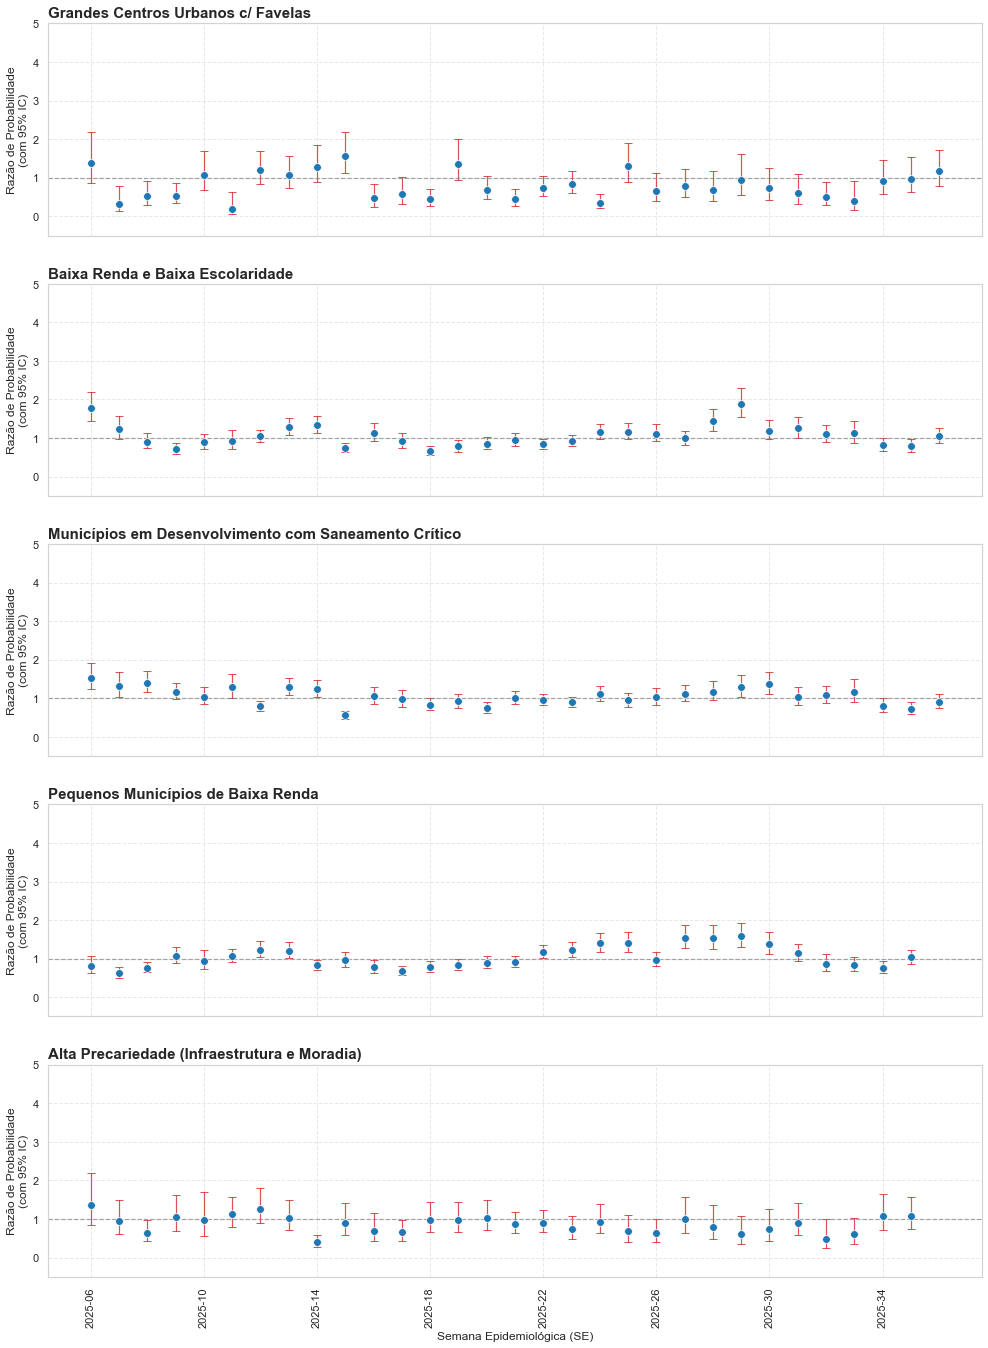

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Style settings for professional presentation
sns.set(style="whitegrid", font_scale=1.3)
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.linewidth": 1.2,
    "grid.color": "lightgray",
    "grid.linestyle": "--",
    "grid.alpha": 0.5,
})

# Filter dataset
df_plot = results_odds[
    (results_odds.outcome == 'Aviso_AESOP') &
    (results_odds.predictor == 'cluster')
][22:].copy()

# Replace labels for readability
df_plot.term = df_plot.term.replace({
    'C(cluster)[T.3]': 'Grandes Centros Urbanos c/ Favelas',
    'C(cluster)[T.4]': 'Baixa Renda e Baixa Escolaridade',
    'C(cluster)[T.5]': 'Municípios em Desenvolvimento com Saneamento Crítico',
    'C(cluster)[T.1]': 'Pequenos Municípios de Baixa Renda',
    'C(cluster)[T.2]': 'Alta Precariedade (Infraestrutura e Moradia)'
})

# Identify unique clusters
terms = df_plot["term"].unique()

# Create subplots
fig, axes = plt.subplots(len(terms), 1, figsize=(14, 3.8 * len(terms)), sharex=True)

if len(terms) == 1:
    axes = [axes]

# Define colors
point_color = "#1f77b4"
ci_color = "#d62728"

for ax, term in zip(axes, terms):
    df_term = df_plot[df_plot["term"] == term].copy()

    # Scatter points
    ax.scatter(
        x=range(len(df_term)),
        y=df_term["OR"],
        color=point_color,
        s=60,
        edgecolor="white",
        linewidth=0.7,
        zorder=3
    )

    # Error bars for 95% CI
    ax.errorbar(
        x=range(len(df_term)),
        y=df_term["OR"],
        yerr=[df_term["OR"] - df_term["2.5%"], df_term["97.5%"] - df_term["OR"]],
        fmt="none",
        ecolor=ci_color,
        capsize=4,
        elinewidth=1.2,
        alpha=0.8,
        zorder=2
    )

    # Horizontal line at OR=1
    ax.axhline(1, color="gray", linestyle="--", linewidth=1.2, alpha=0.7)

    # Labels and titles
    ax.set_title(term, fontsize=15, fontweight="semibold", loc="left")
    ax.set_ylabel("Razão de Probabilidade\n(com 95% IC)", fontsize=12)
    ax.set_ylim(-0.5, 5)
    ax.tick_params(axis='y', labelsize=11)

# X-axis formatting
axes[-1].set_xticks(range(0, len(df_term), 4))
axes[-1].set_xticklabels(df_term["week"].iloc[::4], rotation=90, fontsize=11)
axes[-1].set_xlabel("Semana Epidemiológica (SE)", fontsize=12)

# Adjust layout
plt.tight_layout(h_pad=2)
plt.savefig("/Users/julianeoliveira/Downloads/odds_semanas_2025.svg", dpi=300, bbox_inches="tight")
plt.show()


In [36]:
# Filter dataset
df_plot = results_odds[
    (results_odds.outcome == 'Aviso_AESOP') & 
    (results_odds.predictor == 'cluster')
]

for value in df_plot.term.unique():
    print('Aviso_AESOP',value,\
          round(len(df_plot[(df_plot.term == value) & (df_plot['2.5%'] > 1 )])*100/len(df_plot[(df_plot.term == value)]),1))
    
    
    

Aviso_AESOP C(cluster)[T.1] 34.3
Aviso_AESOP C(cluster)[T.2] 8.6
Aviso_AESOP C(cluster)[T.3] 5.7
Aviso_AESOP C(cluster)[T.4] 22.9
Aviso_AESOP C(cluster)[T.5] 28.6


In [37]:
# Filter dataset
df_plot = results_odds[
    (results_odds.outcome == 'sinal_otc_ivas') & 
    (results_odds.predictor == 'cluster')
]

for value in df_plot.term.unique():
    print('sinal_otc_ivas',value,\
          round(len(df_plot[(df_plot.term == value) & (df_plot['2.5%'] > 1 )])*100/len(df_plot[(df_plot.term == value)]),1))
    
    
    

sinal_otc_ivas C(cluster)[T.1] 14.3
sinal_otc_ivas C(cluster)[T.2] 11.4
sinal_otc_ivas C(cluster)[T.3] 5.7
sinal_otc_ivas C(cluster)[T.4] 20.0
sinal_otc_ivas C(cluster)[T.5] 17.1


In [38]:
# Filter dataset
df_plot = results_odds[
    (results_odds.outcome == 'sinal_ens_ivas') & 
    (results_odds.predictor == 'cluster')
]

for value in df_plot.term.unique():
    print('sinal_ens_ivas',value,\
          round(len(df_plot[(df_plot.term == value) & (df_plot['2.5%'] > 1 )])*100/len(df_plot[(df_plot.term == value)]),1))
    

sinal_ens_ivas C(cluster)[T.1] 31.4
sinal_ens_ivas C(cluster)[T.2] 11.4
sinal_ens_ivas C(cluster)[T.3] 8.6
sinal_ens_ivas C(cluster)[T.4] 40.0
sinal_ens_ivas C(cluster)[T.5] 28.6


In [39]:
# Filter dataset
df_plot = results_odds[
    (results_odds.outcome == 'sinal_ens_ivas_new') & 
    (results_odds.predictor == 'cluster')
]

for value in df_plot.term.unique():
    print('sinal_ens_ivas_new',value,\
          round(len(df_plot[(df_plot.term == value) & (df_plot['2.5%'] > 1 )])*100/len(df_plot[(df_plot.term == value)]),1))
    

sinal_ens_ivas_new C(cluster)[T.1] 20.0
sinal_ens_ivas_new C(cluster)[T.2] 14.3
sinal_ens_ivas_new C(cluster)[T.3] 14.3
sinal_ens_ivas_new C(cluster)[T.4] 20.0
sinal_ens_ivas_new C(cluster)[T.5] 0.0


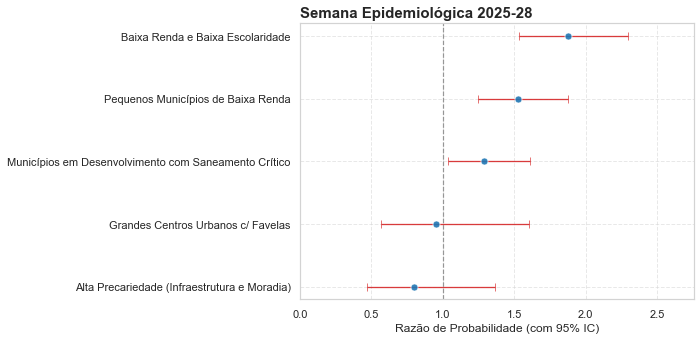

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Styling for professional presentation ---
sns.set(style="whitegrid", font_scale=1.3)
plt.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.linewidth": 1.2,
    "grid.color": "lightgray",
    "grid.linestyle": "--",
    "grid.alpha": 0.5,
})

# --- Filter for the desired week ---
week_to_plot = "2025-28"
df_week = results_odds[
    (results_odds.week == week_to_plot) &
    (results_odds.predictor == 'cluster') &
    (results_odds.outcome == 'Aviso_AESOP')
].copy()

# --- Label replacement for readability ---
df_week["term"] = df_week["term"].replace({
    'C(cluster)[T.3]': 'Grandes Centros Urbanos c/ Favelas',
    'C(cluster)[T.4]': 'Baixa Renda e Baixa Escolaridade',
    'C(cluster)[T.5]': 'Municípios em Desenvolvimento com Saneamento Crítico',
    'C(cluster)[T.1]': 'Pequenos Municípios de Baixa Renda',
    'C(cluster)[T.2]': 'Alta Precariedade (Infraestrutura e Moradia)'
})

# --- Sort by OR for cleaner ordering ---
df_week = df_week.sort_values("OR", ascending=True)

# --- Define consistent colors ---
point_color = "#1f77b4"  # calm blue
ci_color = "#d62728"     # soft red for CI
ref_line_color = "gray"

# --- Create figure ---
plt.figure(figsize=(10, 5))

# --- Plot points with error bars ---
plt.errorbar(
    x=df_week["OR"],
    y=df_week["term"],
    xerr=[
        df_week["OR"] - df_week["2.5%"],
        df_week["97.5%"] - df_week["OR"]
    ],
    fmt="o",
    color=point_color,
    ecolor=ci_color,
    elinewidth=1.3,
    capsize=4,
    markersize=7,
    markeredgecolor="white",
    markeredgewidth=0.7,
    alpha=0.9
)

# --- Add vertical reference line at OR = 1 ---
plt.axvline(1, color=ref_line_color, linestyle="--", linewidth=1.2, alpha=0.8)

# --- Labels and title ---
plt.title(f"Semana Epidemiológica {week_to_plot}", fontsize=15, fontweight="semibold", loc="left")
plt.xlabel("Razão de Probabilidade (com 95% IC)", fontsize=12)
plt.ylabel("")  # omit redundant label

# --- Axis limits and tick formatting ---
plt.xlim(0, max(df_week["97.5%"]) * 1.2)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# --- Layout and save ---
plt.tight_layout()
plt.savefig(f"/Users/julianeoliveira/Downloads/odds_SE_{week_to_plot}.svg", dpi=300, bbox_inches="tight")
plt.show()


# Method Random Forest

In [33]:
# Prepare data to run the model

dta_week = data[data.year_week == '2025-18']#

df_merged = df_soc.merge(
    dta_week,
    left_on="CD_MUN",
    right_on="co_ibge7",
    how="left"   
)

df_merged = df_merged.merge(
    ibp,
    left_on="CD_MUN",
    right_on="ip_cd_m",
    how="left"   
)

df_merged= df_merged.rename(columns = { 'ip_vl_n':'ibp'})

df_merged


# Suppose your variable is called "value" inside df
bins = [-1.7627, -1.0024, -0.4717, 0.2507, 1.0266, 2.7295]
labels = [
    "0", #-1.7627 à -1.0024
    "1", #-1.0023 à -0.4717
    "2", #-0.4717 à 0.2507
    "3", #0.2507 à 1.0265
    "4" #1.0266 à 2.7295
]

df_merged["ibp_cat"] = pd.cut(df_merged["ibp"], bins=bins, labels=labels, include_lowest=True)


# Subset
dta_model = df_merged[['cluster','Aviso AESOP']].dropna() #sinal_ens_ivas


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

# Data
X = dta_model[['cluster']]
y = dta_model['Aviso AESOP']

# Encode cluster
enc = OneHotEncoder(drop="first").fit(X)
X_enc = enc.transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.4, stratify=y, random_state=42)

# Random forest
rf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Feature importance
importances = rf.feature_importances_
print(dict(zip(enc.get_feature_names_out(), importances)))


              precision    recall  f1-score   support

         0.0       0.82      0.60      0.69      1819
         1.0       0.19      0.43      0.26       407

    accuracy                           0.57      2226
   macro avg       0.51      0.51      0.48      2226
weighted avg       0.71      0.57      0.62      2226

[[1090  729]
 [ 234  173]]
{'cluster_1': 0.31613208583756763, 'cluster_2': 0.0873425718178469, 'cluster_3': 0.14137517364148613, 'cluster_4': 0.3288484485720986, 'cluster_5': 0.12630172013100072}


# OLD

In [258]:
# prepare data for analysis
dta_week = data[data.year_week == '2025-36'].copy()
    
df_merged = df_soc.merge(
        dta_week,
        left_on="CD_MUN",
        right_on="co_ibge7",
        how="left"   
    )

df_merged = df_merged.merge(
        ibp,
        left_on="CD_MUN",
        right_on="ip_cd_m",
        how="left"   
    )

df_merged = df_merged.rename(columns={'ip_vl_n':'ibp'})
    
# create ibp categories
df_merged["ibp_cat"] = pd.cut(
        df_merged["ibp"], 
        bins=bins, 
        labels=labels, 
        include_lowest=True
    )

In [259]:
dta_model = df_merged[['cluster','ibp_cat','sinal_ens_ivas']]

In [261]:
dta_model.sinal_ens_ivas.sum()

2.0

In [239]:
# For cluster
or_cluster = odds_ratios_ci(dta_model, predictor="cluster", outcome="sinal_ens_ivas")
print("Odds ratios for cluster:")
print(or_cluster)

# For ibp_cat
or_ibp = odds_ratios_ci(dta_model, predictor="ibp_cat", outcome="sinal_ens_ivas")
print("\nOdds ratios for ibp_cat:")
print(or_ibp)


Odds ratios for cluster:
                     2.5%     97.5%        OR
Intercept        0.029990  0.055184  0.040681
C(cluster)[T.1]  1.158595  2.338663  1.646076
C(cluster)[T.2]  0.214999  1.713430  0.606948
C(cluster)[T.3]  0.328148  2.159620  0.841829
C(cluster)[T.4]  0.861065  1.967708  1.301662
C(cluster)[T.5]  0.807868  1.890366  1.235786

Odds ratios for ibp_cat:
                     2.5%     97.5%        OR
Intercept        0.057269  0.091514  0.072394
C(ibp_cat)[T.1]  0.555620  1.119222  0.788582
C(ibp_cat)[T.2]  0.576936  1.155320  0.816422
C(ibp_cat)[T.3]  0.418782  0.885708  0.609031
C(ibp_cat)[T.4]  0.357979  0.781138  0.528802


<ipython-input-230-c354411916bf>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[predictor] = data[predictor].astype("category")#
<ipython-input-230-c354411916bf>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[predictor] = data[predictor].astype("category")#


In [120]:
counts_clusters = df_merged.groupby(['cluster'])[['atend_totais','atend_ivas','sinal_ens_ivas_new','sinal_ens_ivas','sinal_otc_ivas','Aviso AESOP']].sum().reset_index()

counts_clusters = counts_clusters.astype(int)

n = df_merged['cluster'].value_counts().reset_index().sort_values(by= 'index')

n = n.rename(columns= {'cluster': 'n_cluster'})

counts_clusters = counts_clusters.assign(prop_ivas = round(counts_clusters.atend_ivas*100/counts_clusters.atend_totais,1),
                      )

counts_clusters= counts_clusters.merge(
    n,
    left_on="cluster",
    right_on="index",
    how="left"   
)

counts_clusters = counts_clusters.assign(prop_sinal_ens_ivas_new = round(counts_clusters.sinal_ens_ivas_new/counts_clusters.n_cluster,4),
                       prop_sinal_ens_ivas= round(counts_clusters.sinal_ens_ivas/counts_clusters.n_cluster,4),
                       prop_sinal_otc_ivas= round(counts_clusters.sinal_otc_ivas/counts_clusters.n_cluster,4),
                       prop_Aviso_AESOP= round(counts_clusters['Aviso AESOP']/counts_clusters.n_cluster,4))

In [121]:
counts_clusters[['cluster',  'prop_ivas',  'prop_sinal_ens_ivas_new', 'prop_sinal_ens_ivas',
       'prop_sinal_otc_ivas', 'prop_Aviso_AESOP']].sort_values(by='prop_ivas')


,cluster,prop_ivas,prop_sinal_ens_ivas_new,prop_sinal_ens_ivas,prop_sinal_otc_ivas,prop_Aviso_AESOP
0,0,5.2,0.4000,0.0391,0.1291,0.1527
4,4,5.6,0.3743,0.0503,0.1402,0.1750
1,1,6.4,0.3228,0.0626,0.1368,0.1568
3,3,7.3,0.3947,0.0329,0.0592,0.0789
5,5,7.3,0.2715,0.0477,0.1440,0.1648
2,2,11.8,0.3855,0.0241,0.1265,0.1446


In [122]:
counts_ibp = df_merged.groupby(['ibp_cat'])[['atend_totais','atend_ivas','sinal_ens_ivas_new','sinal_ens_ivas','sinal_otc_ivas','Aviso AESOP']].sum().reset_index()
counts_ibp = counts_ibp.astype(int)
counts_ibp = counts_ibp.assign(prop_ivas = round(counts_ibp.atend_ivas*100/counts_ibp.atend_totais,1),
                      )    

n = df_merged['ibp_cat'].value_counts().reset_index().sort_values(by= 'index')

n = n.rename(columns= {'ibp_cat': 'n_ibp_cat'})

n['index'] = n['index'].astype(int)

counts_ibp= counts_ibp.merge(
    n,
    left_on="ibp_cat",
    right_on="index",
    how="left"   
)

counts_ibp = counts_ibp.assign(prop_sinal_ens_ivas_new = round(counts_ibp.sinal_ens_ivas_new/counts_ibp.n_ibp_cat,4),
                       prop_sinal_ens_ivas= round(counts_ibp.sinal_ens_ivas/counts_ibp.n_ibp_cat,4),
                       prop_sinal_otc_ivas= round(counts_ibp.sinal_otc_ivas/counts_ibp.n_ibp_cat,4),
                       prop_Aviso_AESOP= round(counts_ibp['Aviso AESOP']/counts_ibp.n_ibp_cat,4))

In [123]:
counts_ibp

,ibp_cat,atend_totais,atend_ivas,sinal_ens_ivas_new,sinal_ens_ivas,sinal_otc_ivas,Aviso AESOP,prop_ivas,index,n_ibp_cat,prop_sinal_ens_ivas_new,prop_sinal_ens_ivas,prop_sinal_otc_ivas,prop_Aviso_AESOP
0,0,3864370,261822,361,75,154,174,6.8,0,1113,0.3243,0.0674,0.1384,0.1563
1,1,1469729,91561,336,60,159,180,6.2,1,1114,0.3016,0.0539,0.1427,0.1616
2,2,1068749,70310,359,62,144,177,6.6,2,1113,0.3226,0.0557,0.1294,0.1590
3,3,1093795,61945,419,47,133,161,5.7,3,1113,0.3765,0.0422,0.1195,0.1447
4,4,844353,49838,431,41,161,190,5.9,4,1112,0.3876,0.0369,0.1448,0.1709


# Study if socio influence the warnings

In [79]:
print(contingency)
print(expected)


Aviso AESOP   0.0  1.0
cluster               
0             932  168
1            1813  338
2             142   24
3             139   12
4             853  181
5             802  159
[[ 925.59769908  174.40230092]
 [1809.96422793  341.03577207]
 [ 139.68110732   26.31889268]
 [ 127.05932051   23.94067949]
 [ 870.06183714  163.93816286]
 [ 808.63580802  152.36419198]]


In [80]:
obs = contingency.values
exp = expected
contrib = (obs - exp)**2 / exp
pd.DataFrame(contrib, index=contingency.index, columns=contingency.columns)


Aviso AESOP,0.0,1.0
cluster,,
0,0.044284,0.235028
1,0.005092,0.027023
2,0.038497,0.204312
3,1.122152,5.955546
4,0.334581,1.775708
5,0.054455,0.289005


In [ ]:
#cluster3 × warning status cells explain most of the chi² = 10.09

In [81]:
risk = contingency.div(contingency.sum(axis=1), axis=0)[1.0]
print(risk)


cluster
0    0.152727
1    0.157136
2    0.144578
3    0.079470
4    0.175048
5    0.165453
Name: 1.0, dtype: float64


Cluster 3: observed much fewer warnings (12) than expected (24) → seems “protected”.
Cluster 4: observed more warnings (181) than expected (164) → slightly more risk.
Other clusters: observed vs expected is close.
So: most of the chi² signal comes from cluster 3 (fewer warnings than expected) and cluster 4 (slightly more warnings than expected).

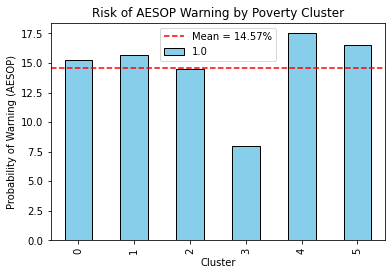

In [85]:
import matplotlib.pyplot as plt

(risk*100).plot(kind="bar", color="skyblue", edgecolor="black")
plt.axhline(risk.mean()*100, color="red", linestyle="--", label=f"Mean = {risk.mean():.2%}")
plt.ylabel("Probability of Warning (AESOP)")
plt.xlabel("Cluster")
plt.title("Risk of AESOP Warning by Poverty Cluster")
plt.legend()
plt.show()


# Cluster com Sinal_ens_ivas (APS)

In [86]:
# Subset
dta_model = df_merged[['cluster','sinal_ens_ivas']].dropna() #sinal_ens_ivas

In [87]:
dta_model.head()

,cluster,sinal_ens_ivas
0,0,0.0
1,5,0.0
2,4,0.0
3,5,0.0
4,0,0.0


In [89]:
contingency = pd.crosstab(dta_model['cluster'], dta_model['sinal_ens_ivas'])
chi2, p, dof, expected = stats.chi2_contingency(contingency)
print(f"Chi2={chi2:.2f}, p={p:.3g}")

Chi2=13.00, p=0.0234


In [90]:
print(contingency)
print(expected)


sinal_ens_ivas   0.0  1.0
cluster                  
0               1057   43
1               2016  135
2                162    4
3                146    5
4                982   52
5                915   46
[[1043.64551501   56.35448499]
 [2040.80136617  110.19863383]
 [ 157.4955959     8.5044041 ]
 [ 143.26406615    7.73593385]
 [ 981.02678411   52.97321589]
 [ 911.76667266   49.23332734]]


In [91]:
obs = contingency.values
exp = expected
contrib = (obs - exp)**2 / exp
pd.DataFrame(contrib, index=contingency.index, columns=contingency.columns)


sinal_ens_ivas,0.0,1.0
cluster,,
0,0.170884,3.164651
1,0.301405,5.581809
2,0.128827,2.385782
3,0.052249,0.967606
4,0.000965,0.017880
5,0.011466,0.212344


In [92]:
risk = contingency.div(contingency.sum(axis=1), axis=0)[1.0]
print(risk)


cluster
0    0.039091
1    0.062762
2    0.024096
3    0.033113
4    0.050290
5    0.047867
Name: 1.0, dtype: float64


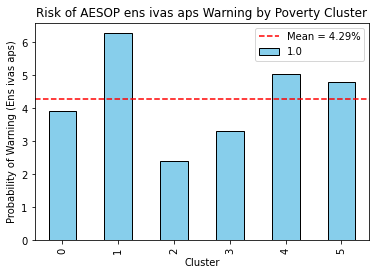

In [93]:
import matplotlib.pyplot as plt

(risk*100).plot(kind="bar", color="skyblue", edgecolor="black")
plt.axhline(risk.mean()*100, color="red", linestyle="--", label=f"Mean = {risk.mean():.2%}")
plt.ylabel("Probability of Warning (Ens ivas aps)")
plt.xlabel("Cluster")
plt.title("Risk of AESOP ens ivas aps Warning by Poverty Cluster")
plt.legend()
plt.show()


1) Chi-square test
Chi² = 13.00, p = 0.0234
Since p < 0.05, there is statistically significant evidence that the probability of a surge signal (sinal_ens_ivas) depends on the poverty cluster.
This means that clusters are not homogeneous: some are at higher risk than others.
    
2) Observed vs expected counts
Example:
Cluster 1: observed 135 surges, expected ~110 → more surges than expected.
Cluster 0: observed 43 surges, expected ~56 → fewer surges than expected.
Cluster 2: observed 4 surges, expected ~9 → fewer surges than expected.
Cluster 3: observed 5 surges, expected ~8 → fewer surges than expected.
Cluster 4: observed 52 surges, expected ~53 → about expected.
Cluster 5: observed 46 surges, expected ~49 → about expected.
Result: The main deviation is cluster 1 having more surges than expected.
    
3) cluster  standardized residual (sinal=1)
0   ~ -2.17  → fewer surges than expected
1   ~ +2.43  → more surges than expected
2   ~ -1.54  → fewer surges than expected
3   ~ -0.97  → fewer surges than expected
4   ~ -0.13  → about expected
5   ~ -0.43  → about expected

    
Interpretation: the significant association is mostly driven by cluster 1 (excess surges) and cluster 0 (deficit of surges).

4) Risk of surges:
Cluster 1: highest risk (6.3%) — about 1.6× the risk of cluster 0.
Cluster 0: baseline risk (3.9%).
Cluster 2: lowest risk (2.4%).
Clusters 3, 4, 5: intermediate (3.3–5%).

The probability of detecting a surge (sinal_ens_ivas) differs significantly across poverty clusters (χ² = 13.0, p = 0.023). The strongest pattern is that cluster 1 shows a significantly higher risk of surge (6.3%) compared to other clusters (average ~4%), while cluster 0 (3.9%) and especially cluster 2 (2.4%) show fewer surges than expected. Clusters 3, 4, and 5 are close to the overall average, with moderate risk levels.
This suggests that socioeconomic clustering is associated with differential risk of surge detection, with cluster 1 standing out as the most vulnerable group.

### 1. Risk table (already computed)

```
Cluster   Risk of surge
0         0.0391   (3.9%)
1         0.0628   (6.3%)
2         0.0241   (2.4%)
3         0.0331   (3.3%)
4         0.0503   (5.0%)
5         0.0479   (4.8%)
```

---

### 2. Relative Risk (RR)

Formula:
$$
RR_i = \frac{Risk(cluster=i)}{Risk(cluster=0)}
$$

* Cluster 0 → RR = 1.00 (reference)
* Cluster 1 → 0.0628 / 0.0391 ≈ **1.61** → 61% higher risk
* Cluster 2 → 0.0241 / 0.0391 ≈ **0.62** → 38% lower risk
* Cluster 3 → 0.0331 / 0.0391 ≈ **0.85** → 15% lower risk
* Cluster 4 → 0.0503 / 0.0391 ≈ **1.29** → 29% higher risk
* Cluster 5 → 0.0479 / 0.0391 ≈ **1.22** → 22% higher risk

---

### 3. Odds Ratios (OR)

Formula:
$$
OR_i = \frac{(p_i / (1 - p_i))}{(p_0 / (1 - p_0))}
$$

* Cluster 0 → OR = 1.00 (reference)
* Cluster 1 → ≈ **1.65**
* Cluster 2 → ≈ **0.61**
* Cluster 3 → ≈ **0.84**
* Cluster 4 → ≈ **1.29**
* Cluster 5 → ≈ **1.22**

---

### 4. Interpretation

* **Cluster 1**: clearly the most at risk (RR ≈ 1.6, OR ≈ 1.65) → significantly more surge signals than baseline.
* **Cluster 2**: least at risk (RR ≈ 0.62, OR ≈ 0.61) → fewer surge signals than baseline.
* **Cluster 3**: also somewhat lower risk (RR ≈ 0.85).
* **Clusters 4 and 5**: slightly elevated risk (RR ~1.2–1.3).

---

✅ **Summary (epidemiological style):**

> Compared to cluster 0, cities in cluster 1 have about **1.6 times the risk** of experiencing a surge signal. In contrast, cluster 2 shows a substantially lower risk (about 40% lower). Clusters 4 and 5 have modestly elevated risks, while cluster 3 is slightly below baseline.




# Ibp com Aviso AESOP (APS + OTC)

In [94]:
# Subset
dta_model = df_merged[['ibp_cat','Aviso AESOP']].dropna() #sinal_ens_ivas

In [95]:
dta_model.head()

,ibp_cat,Aviso AESOP
0,3,0.0
1,2,0.0
2,4,0.0
3,2,0.0
4,2,0.0


In [96]:
contingency = pd.crosstab(dta_model['ibp_cat'], dta_model['Aviso AESOP'])
chi2, p, dof, expected = stats.chi2_contingency(contingency)
print(f"Chi2={chi2:.2f}, p={p:.3g}")

Chi2=3.01, p=0.557


In [97]:
print(contingency)
print(expected)


Aviso AESOP  0.0  1.0
ibp_cat              
0            937  174
1            931  180
2            934  177
3            952  161
4            922  190
[[934.69521411 176.30478589]
 [934.69521411 176.30478589]
 [934.69521411 176.30478589]
 [936.37783375 176.62216625]
 [935.53652393 176.46347607]]


In [98]:
obs = contingency.values
exp = expected
contrib = (obs - exp)**2 / exp
pd.DataFrame(contrib, index=contingency.index, columns=contingency.columns)


Aviso AESOP,0.0,1.0
ibp_cat,,
0,0.005683,0.030130
1,0.014609,0.077449
2,0.000517,0.002741
3,0.260634,1.381775
4,0.195864,1.038388


In [99]:
risk = contingency.div(contingency.sum(axis=1), axis=0)[1.0]
print(risk)


ibp_cat
0    0.156616
1    0.162016
2    0.159316
3    0.144654
4    0.170863
Name: 1.0, dtype: float64


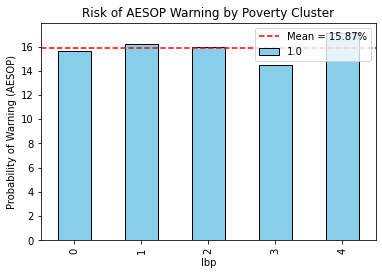

In [100]:
import matplotlib.pyplot as plt

(risk*100).plot(kind="bar", color="skyblue", edgecolor="black")
plt.axhline(risk.mean()*100, color="red", linestyle="--", label=f"Mean = {risk.mean():.2%}")
plt.ylabel("Probability of Warning (AESOP)")
plt.xlabel("Ibp")
plt.title("Risk of AESOP Warning by Poverty Cluster")
plt.legend()
plt.show()


# Ibp com Sinal_ens_ivas (APS)

In [101]:
# Subset
dta_model = df_merged[['ibp_cat','sinal_ens_ivas']].dropna() #sinal_ens_ivas

In [102]:
dta_model.head()

,ibp_cat,sinal_ens_ivas
0,3,0.0
1,2,0.0
2,4,0.0
3,2,0.0
4,2,0.0


In [103]:
contingency = pd.crosstab(dta_model['ibp_cat'], dta_model['sinal_ens_ivas'])
chi2, p, dof, expected = stats.chi2_contingency(contingency)
print(f"Chi2={chi2:.2f}, p={p:.3g}")

Chi2=13.27, p=0.01


In [104]:
print(contingency)
print(expected)


sinal_ens_ivas   0.0  1.0
ibp_cat                  
0               1036   75
1               1051   60
2               1049   62
3               1066   47
4               1071   41
[[1054.03076646   56.96923354]
 [1054.03076646   56.96923354]
 [1054.03076646   56.96923354]
 [1055.92821159   57.07178841]
 [1054.97948902   57.02051098]]


In [105]:
obs = contingency.values
exp = expected
contrib = (obs - exp)**2 / exp
pd.DataFrame(contrib, index=contingency.index, columns=contingency.columns)


sinal_ens_ivas,0.0,1.0
ibp_cat,,
0,0.308443,5.706739
1,0.008715,0.161237
2,0.024011,0.444251
3,0.096068,1.777427
4,0.243281,4.501131


In [106]:
risk = contingency.div(contingency.sum(axis=1), axis=0)[1.0]
print(risk)


ibp_cat
0    0.067507
1    0.054005
2    0.055806
3    0.042228
4    0.036871
Name: 1.0, dtype: float64


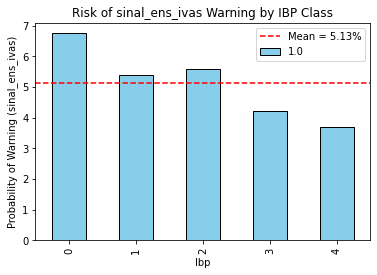

In [107]:
import matplotlib.pyplot as plt

(risk*100).plot(kind="bar", color="skyblue", edgecolor="black")
plt.axhline(risk.mean()*100, color="red", linestyle="--", label=f"Mean = {risk.mean():.2%}")
plt.ylabel("Probability of Warning (sinal_ens_ivas)")
plt.xlabel("Ibp")
plt.title("Risk of sinal_ens_ivas Warning by IBP Class")
plt.legend()
plt.show()


Chi-squared test: Significant association (p=0.01) between ibp_cat and sinal_ens_ivas.
Observed vs expected counts: Categories 0–2 have more positive events than expected; 3–4 have fewer.
Proportions: Clear decreasing trend in positive rates as ibp_cat increases → higher ibp_cat is linked to lower likelihood of positive sinal_ens_ivas.
Per-cell contributions: Extreme deviations in first and last categories drive the chi-squared significance.
In plain language: your categorical variable ibp_cat seems inversely associated with the event sinal_ens_ivas.

In [52]:
# Prepare data to run the model

dta_week = data[data.year_week == '2025-18']#

df_merged = df_soc.merge(
    dta_week,
    left_on="CD_MUN",
    right_on="co_ibge7",
    how="left"   
)

df_merged = df_merged.merge(
    ibp,
    left_on="CD_MUN",
    right_on="ip_cd_m",
    how="left"   
)

df_merged= df_merged.rename(columns = { 'ip_vl_n':'ibp'})

df_merged


# Suppose your variable is called "value" inside df
bins = [-1.7627, -1.0024, -0.4717, 0.2507, 1.0266, 2.7295]
labels = [
    "0", #-1.7627 à -1.0024
    "1", #-1.0023 à -0.4717
    "2", #-0.4717 à 0.2507
    "3", #0.2507 à 1.0265
    "4" #1.0266 à 2.7295
]

df_merged["ibp_cat"] = pd.cut(df_merged["ibp"], bins=bins, labels=labels, include_lowest=True)


# Subset
dta_model = df_merged[['cluster','Aviso AESOP']].dropna() #sinal_ens_ivas


In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

# Data
X = dta_model[['cluster']]
y = dta_model['Aviso AESOP']

# Encode cluster
enc = OneHotEncoder(drop="first").fit(X)
X_enc = enc.transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.4, stratify=y, random_state=42)

# Random forest
rf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Feature importance
importances = rf.feature_importances_
print(dict(zip(enc.get_feature_names_out(), importances)))


              precision    recall  f1-score   support

         0.0       0.82      0.60      0.69      1819
         1.0       0.19      0.43      0.26       407

    accuracy                           0.57      2226
   macro avg       0.51      0.51      0.48      2226
weighted avg       0.71      0.57      0.62      2226

[[1090  729]
 [ 234  173]]
{'cluster_1': 0.4445256035937225, 'cluster_2': 0.06828312950376954, 'cluster_3': 0.22299014496967878, 'cluster_4': 0.16445577738325987, 'cluster_5': 0.0997453445495692}


In [55]:
results[results.year_week == '2025-18']

,epiyear,epiweek,epidemi_cal_start,year_week,chi2_Aviso AESOP_cluster,p_Aviso AESOP_cluster,chi2_Aviso AESOP_ibp_cat,p_Aviso AESOP_ibp_cat,chi2_sinal_otc_ivas_cluster,p_sinal_otc_ivas_cluster,chi2_sinal_otc_ivas_ibp_cat,p_sinal_otc_ivas_ibp_cat,chi2_sinal_ens_ivas_cluster,p_sinal_ens_ivas_cluster,chi2_sinal_ens_ivas_ibp_cat,p_sinal_ens_ivas_ibp_cat,chi2_sinal_ens_ivas_new_cluster,p_sinal_ens_ivas_new_cluster,chi2_sinal_ens_ivas_new_ibp_cat,p_sinal_ens_ivas_new_ibp_cat
132,2025,18,2025-04-27,2025-18,14.453299,0.012972,11.302895,0.023363,13.862348,0.016508,11.149579,0.024933,20.966534,0.000822,24.170418,0.000074,9.656231,0.085583,12.78078,0.012398


In [33]:
# Subset
dta_model = df_merged[['ibp','Aviso AESOP']].dropna() #sinal_ens_ivas

In [54]:
from sklearn.preprocessing import StandardScaler
# Define features and target
feature_cols = ['ibp']  
    
X = dta_model[feature_cols]
y = dta_model['Aviso AESOP']


X_scaled = StandardScaler().fit_transform(X)



# Fit model

clf = LogisticRegression(class_weight='balanced', max_iter=1000)
#clf.fit(X, y)
clf.fit(X_scaled, y)

# Predict and attach results
y_pred = clf.predict(X_scaled) #X)
risk_probs = clf.predict_proba(X)[:, 1]

dta_model['risk_probs_ibp'] = risk_probs

/Users/julianeoliveira/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [55]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print(scores.mean())


0.5081117309097289


In [56]:
np.exp(clf.coef_)


array([[1.03163566]])

In [57]:
risk_probs

array([0.5073252 , 0.49924345, 0.51173534, ..., 0.50632795, 0.49803346,
       0.50843371])

In [58]:
dta_model[dta_model['Aviso AESOP']== 1]

,ibp,Aviso AESOP,risk_probs_space,risk_probs_ibp
7,-1.0456,1.0,0.491775,0.491775
22,0.5820,1.0,0.504448,0.504448
32,1.1717,1.0,0.509039,0.509039
39,-1.5923,1.0,0.487521,0.487521
52,-0.6382,1.0,0.494947,0.494947
...,...,...,...,...
5531,0.8167,1.0,0.506275,0.506275
5538,1.3895,1.0,0.510734,0.510734
5542,-0.1771,1.0,0.498537,0.498537
5543,-0.4461,1.0,0.496443,0.496443


In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

# Features and target
X = dta_model[['ibp']]
y = dta_model['Aviso AESOP']

# Split data (to assess prediction)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Fit model
clf = LogisticRegression(class_weight='balanced', max_iter=1000)
clf.fit(X_train, y_train)

# Predict probabilities
dta_model['risk_probs_space'] = clf.predict_proba(X)[:, 1]


In [64]:
y_pred_proba = clf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC:", auc)


AUC: 0.5183499407029059


In [65]:
import numpy as np

coef = clf.coef_[0][0]
odds_ratio = np.exp(coef)
print(f"Coefficient for ibp: {coef:.4f}")
print(f"Odds ratio: {odds_ratio:.3f}")


Coefficient for ibp: 0.0113
Odds ratio: 1.011


/Users/julianeoliveira/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


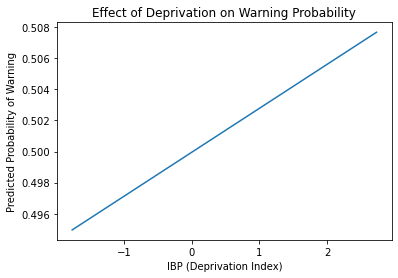

In [66]:
import numpy as np
import matplotlib.pyplot as plt

ibp_range = np.linspace(X['ibp'].min(), X['ibp'].max(), 100).reshape(-1, 1)
probs = clf.predict_proba(ibp_range)[:, 1]

plt.plot(ibp_range, probs)
plt.xlabel('IBP (Deprivation Index)')
plt.ylabel('Predicted Probability of Warning')
plt.title('Effect of Deprivation on Warning Probability')
plt.show()


In [68]:
dta_model[dta_model['Aviso AESOP'] ==1]

,ibp,Aviso AESOP,risk_probs_space,risk_probs_ibp
7,-1.0456,1.0,0.496985,0.491775
22,0.5820,1.0,0.501597,0.504448
32,1.1717,1.0,0.503268,0.509039
39,-1.5923,1.0,0.495436,0.487521
52,-0.6382,1.0,0.498139,0.494947
...,...,...,...,...
5531,0.8167,1.0,0.502262,0.506275
5538,1.3895,1.0,0.503885,0.510734
5542,-0.1771,1.0,0.499446,0.498537
5543,-0.4461,1.0,0.498684,0.496443


# Second approach

In [22]:
lst = []

for date in final_result.year_week.unique(): # aqui, a cada update dos dados, precisa rodar so para ultima semana

    data = final_result[final_result.year_week == date].copy()

    # Define features and target
    feature_cols = [
        'dqi', 'prob_gro_trend_ivas', #'privacao',
        'num_viz_aviso', 'num_paths_covered' 
    ]  #'aviso_pip_ivas_lag_1', 'aviso_pip_ivas_lag_2', 'aviso_pip_ivas_lag_3', 'aviso_pip_ivas_lag_4', 
        #'aviso_aps_ivas_lag_1', 'aviso_aps_ivas_lag_2', 'aviso_aps_ivas_lag_3','per_mob_coverage'

    X = data[feature_cols]
    y = data['aviso_aesop_ivas']

    # check if we have enough data
    #if len(set_muni) < 5 or y.nunique() < 2:
    #    print(f"Skipping {code}: not enough data or no variation in target.")
    #    continue

    # Fit model

    clf = LogisticRegression(class_weight='balanced', max_iter=1000)
    clf.fit(X, y)

    # Predict and attach results
    y_pred = clf.predict(X)
    risk_probs = clf.predict_proba(X)[:, 1]

    data['risk_probs_space'] = risk_probs
    data['aviso_aesop_pred_space'] = y_pred

    lst.append(data)


In [23]:
final_result2 = pd.concat(lst)

In [ ]:
# Se quiser, salva esse final_result2  em uma pasta separada no HPC : final_result2_data

In [24]:
final_result2 = final_result2.assign(risk_prob_com = final_result2['risk_probs_time']*final_result2['risk_probs_space'])

In [25]:
final_result2.columns

Index(['co_uf', 'nm_uf', 'sigla_uf', 'co_ibge', 'co_ibge7', 'nm_municipio',
       'epiyear', 'epiweek', 'year_week', 'epidemi_cal_start',
       'epidemi_cal_end', 'year_week_ts', 'aviso_aesop_ivas', 'aviso_pip_ivas',
       'aviso_aps_ivas', 'perc_missing', 'perc_completude', 'diff_2w',
       'diff_3w', 'sum_miss', 'completude', 'tempestividade', 'dqi',
       'prob_gro_trend_ivas', 'vizinho_com_aviso', 'num_viz_aviso',
       'num_municpios_vizinhos', 'num_paths_covered', 'per_mob_coverage',
       'privacao', 'aviso_pip_ivas_lag_1', 'aviso_pip_ivas_lag_2',
       'aviso_pip_ivas_lag_3', 'aviso_pip_ivas_lag_4', 'aviso_aps_ivas_lag_1',
       'aviso_aps_ivas_lag_2', 'aviso_aps_ivas_lag_3', 'risk_probs_time',
       'aviso_aesop_pred_time', 'risk_probs_space', 'aviso_aesop_pred_space',
       'risk_prob_com'],
      dtype='object')

In [30]:
final_result2[final_result2.nm_municipio == 'Rio de Janeiro']

,co_uf,nm_uf,sigla_uf,co_ibge,co_ibge7,nm_municipio,epiyear,epiweek,year_week,epidemi_cal_start,...,aviso_pip_ivas_lag_3,aviso_pip_ivas_lag_4,aviso_aps_ivas_lag_1,aviso_aps_ivas_lag_2,aviso_aps_ivas_lag_3,risk_probs_time,aviso_aesop_pred_time,risk_probs_space,aviso_aesop_pred_space,risk_prob_com
1446286,33,Rio de Janeiro,RJ,330455,3304557,Rio de Janeiro,2023,42,2023-42,2023-10-15,...,0,0,0,0,0,0.382428,0,4.468516e-01,0,1.708888e-01
1446287,33,Rio de Janeiro,RJ,330455,3304557,Rio de Janeiro,2023,43,2023-43,2023-10-22,...,0,0,0,0,0,0.201786,0,2.789876e-01,0,5.629569e-02
1446288,33,Rio de Janeiro,RJ,330455,3304557,Rio de Janeiro,2023,44,2023-44,2023-10-29,...,0,0,0,0,0,0.976054,1,7.727354e-01,1,7.542313e-01
1446289,33,Rio de Janeiro,RJ,330455,3304557,Rio de Janeiro,2023,45,2023-45,2023-11-05,...,0,0,0,0,0,0.560515,1,3.573349e-01,0,2.002915e-01
1446290,33,Rio de Janeiro,RJ,330455,3304557,Rio de Janeiro,2023,46,2023-46,2023-11-12,...,0,0,0,0,0,0.708193,1,4.840820e-01,0,3.428233e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446373,33,Rio de Janeiro,RJ,330455,3304557,Rio de Janeiro,2025,25,2025-25,2025-06-15,...,0,0,0,0,0,0.119692,0,3.204000e-03,0,3.834921e-04
1446374,33,Rio de Janeiro,RJ,330455,3304557,Rio de Janeiro,2025,26,2025-26,2025-06-22,...,0,0,0,0,0,0.197269,0,4.168471e-01,0,8.223118e-02
1446375,33,Rio de Janeiro,RJ,330455,3304557,Rio de Janeiro,2025,27,2025-27,2025-06-29,...,0,0,0,0,0,0.098298,0,2.135952e-09,0,2.099592e-10
1446376,33,Rio de Janeiro,RJ,330455,3304557,Rio de Janeiro,2025,28,2025-28,2025-07-06,...,0,0,0,0,0,0.108385,0,1.122766e-12,0,1.216913e-13


/tmp/ipykernel_929525/3145152830.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_muni['epidemi_cal_start'] = pd.to_datetime(set_muni['epidemi_cal_start'])


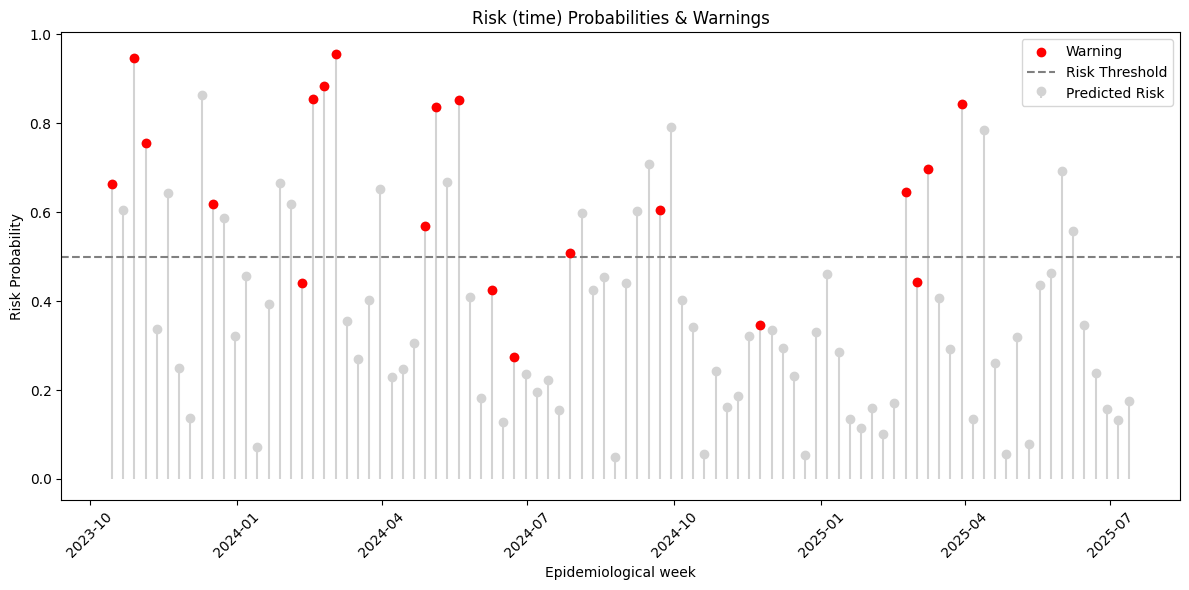

In [31]:
set_muni = final_result2[final_result2.co_ibge == '292740']

set_muni['epidemi_cal_start'] = pd.to_datetime(set_muni['epidemi_cal_start'])

plt.figure(figsize=(12, 6))
plt.stem(set_muni['epidemi_cal_start'], set_muni['risk_probs_time'],
         basefmt=" ", linefmt='lightgray', markerfmt='o', label='Predicted Risk')

plt.scatter(set_muni.loc[set_muni['aviso_aesop_ivas'] == 1, 'epidemi_cal_start'],
            set_muni.loc[set_muni['aviso_aesop_ivas'] == 1, 'risk_probs_time'],
            color='red', label='Warning', zorder=3)

plt.axhline(0.5, color='gray', linestyle='--', label='Risk Threshold')
plt.xticks(rotation=45)
plt.title('Risk (time) Probabilities & Warnings')
plt.xlabel('Epidemiological week')
plt.ylabel('Risk Probability')
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.show()

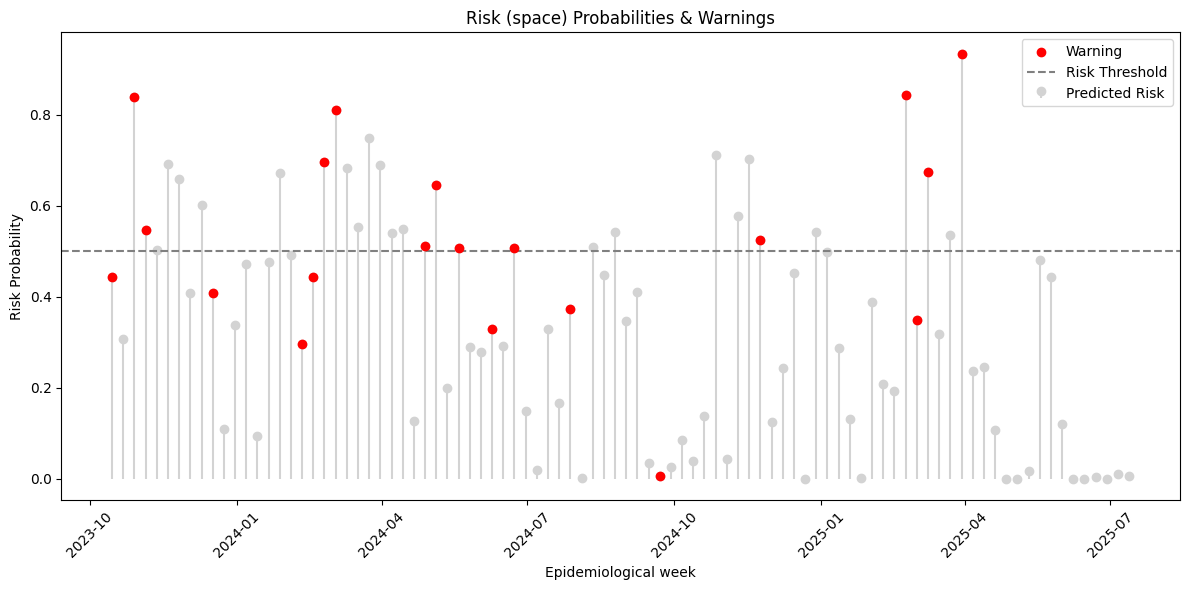

In [32]:
plt.figure(figsize=(12, 6))
plt.stem(set_muni['epidemi_cal_start'], set_muni['risk_probs_space'],
         basefmt=" ", linefmt='lightgray', markerfmt='o', label='Predicted Risk')

plt.scatter(set_muni.loc[set_muni['aviso_aesop_ivas'] == 1, 'epidemi_cal_start'],
            set_muni.loc[set_muni['aviso_aesop_ivas'] == 1, 'risk_probs_space'],
            color='red', label='Warning', zorder=3)

plt.axhline(0.5, color='gray', linestyle='--', label='Risk Threshold')
plt.xticks(rotation=45)
plt.title('Risk (space) Probabilities & Warnings')
plt.xlabel('Epidemiological week')
plt.ylabel('Risk Probability')
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.show()

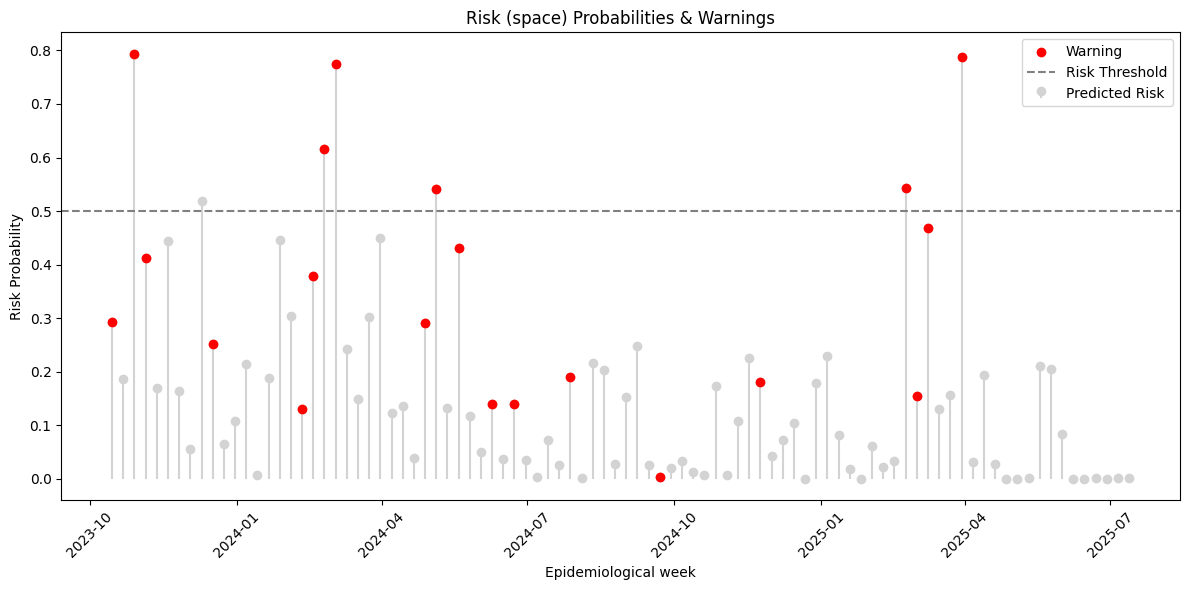

In [33]:
plt.figure(figsize=(12, 6))
plt.stem(set_muni['epidemi_cal_start'], set_muni['risk_prob_com'],
         basefmt=" ", linefmt='lightgray', markerfmt='o', label='Predicted Risk')

plt.scatter(set_muni.loc[set_muni['aviso_aesop_ivas'] == 1, 'epidemi_cal_start'],
            set_muni.loc[set_muni['aviso_aesop_ivas'] == 1, 'risk_prob_com'],
            color='red', label='Warning', zorder=3)

plt.axhline(0.5, color='gray', linestyle='--', label='Risk Threshold')
plt.xticks(rotation=45)
plt.title('Risk (space) Probabilities & Warnings')
plt.xlabel('Epidemiological week')
plt.ylabel('Risk Probability')
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.show()

In [35]:
#final_result2.risk_prob_com.describe()

In [36]:
#final_result2[final_result2.risk_prob_com >= 0.9][['nm_municipio','year_week','aviso_aesop_ivas','risk_probs_time','risk_probs_space','risk_prob_com']]

In [37]:
#final_result2[(final_result2.year_week == '2025-28') & (final_result2.risk_prob_com >= 0.6)][['nm_municipio','year_week','aviso_aesop_ivas','risk_probs_time','risk_probs_space','risk_prob_com']]

In [21]:
#dta = final_result2[(final_result2.risk_probs_time >= 0.5) & (final_result2.risk_probs_space >= 0.9)][['nm_municipio','year_week','aviso_aesop_ivas','risk_probs_time','risk_probs_space']]

In [142]:
#print(classification_report(y, y_pred))

In [22]:
#data[(data.risk_probs >= 0.9) & (data.aviso_aesop_ivas == 1)][['nm_municipio',
#        'year_week',  'aviso_aesop_ivas', 
#        'dqi', 'prob_gro_trend_ivas', 'privacao',
#        'num_viz_aviso', 'num_paths_covered', 'risk_probs',
#       'aviso_aesop_pred']]

In [121]:
# --- Load shapefile of Brazilian municipalities ---

#gdf = gpd.read_file("/opt/storage/raw/aesop/visualization/shape_file_muni/BR_Municipios_2022.shp")  
# --- Merge risk data with geodata ---
#gdf = gdf.assign(co_ibge7 = gdf['CD_MUN'].astype(str))  # Standard IBGE code column
#data = data.assign(co_ibge7 = data['co_ibge7'].astype(str))
#merged = gdf.merge(data[['co_ibge7', 'aviso_aesop_ivas', 'risk_probs']], on="co_ibge7", how="left")

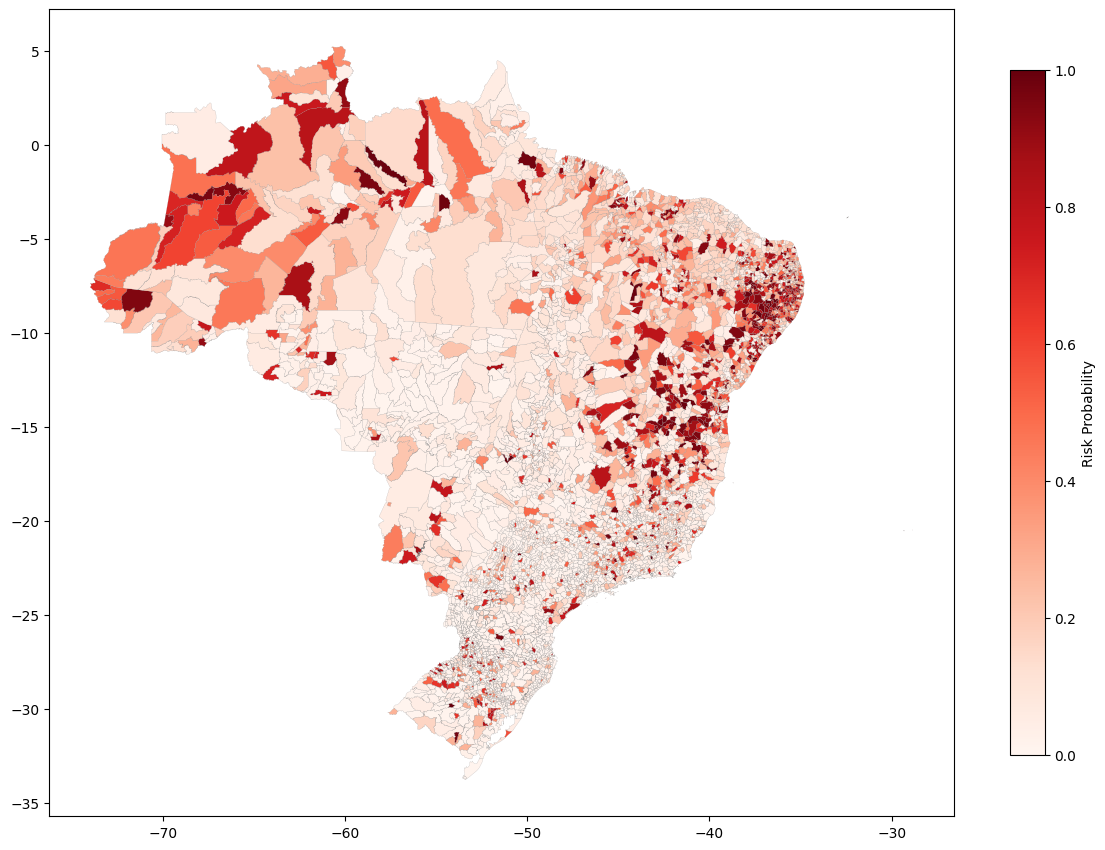

In [122]:
# --- Plotting ---
#fig, ax = plt.subplots(1, 1, figsize=(12, 14))

# 1. Plot all municipalities, coloring by risk
#merged.plot(
#    column='risk_probs',
 #   cmap='Reds',
 #  linewidth=0.1,
#    edgecolor='grey',
 #   legend=True,
 #   vmin=0,                # Set the color scale min
  #  vmax=1,                # Set the color scale max
 #   legend_kwds={
 #       'label': "Risk Probability",
 #       'shrink': 0.5,     # Reduce height of the colorbar (0.0 to 1.0)
 #       'orientation': 'vertical'
 #   },
 #   ax=ax
#)

# 2. Highlight municipalities with aviso_aesop_ivas == 1
#pins = merged[merged['aviso_aesop_ivas'] == 1]
#pins.plot(ax=ax, color='blue', markersize=5, marker='o', label='Aviso AESOP')


# 3. Customize
#ax.set_title("Brazilian Municipalities: Risk Levels and AESOP Warnings", fontsize=14)
#ax.axis('off')
#plt.legend(loc='lower left')

#plt.tight_layout()
#plt.show()
